```
pip install scikit-learn
```

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from plotnine import *
import plotnine as p9
import re
from scrapy import Selector
import requests as requests
import json
import statsmodels.api as sm
import spotipy
import base64
from requests import post
from spotipy.oauth2 import SpotifyClientCredentials
from datetime import datetime
from sklearn import *
from base64 import *

In [2]:
merged_df = pd.read_csv('../data/merged.csv')

In [3]:
merged_df.head()

,Unnamed: 0,video_id,title,channel_id,channel_title,description,like_count,view_count,comment_count,wikipedia_categories
0,0,kJQP7kiw5Fk,Luis Fonsi - Despacito ft. Daddy Yankee,UCLp8RBhQHu9wSsq62j_Md6A,LuisFonsiVEVO,Despacito” disponible ya en todas las platafor...,52536208,8327497494,4228228,"['https://en.wikipedia.org/wiki/Music', 'https..."
1,1,JGwWNGJdvx8,Ed Sheeran - Shape of You (Official Music Video),UC0C-w0YjGpqDXGB8IHb662A,Ed Sheeran,The official music video for Ed Sheeran - Shap...,32323299,6149151955,1146136,"['https://en.wikipedia.org/wiki/Music', 'https..."
2,2,RgKAFK5djSk,Wiz Khalifa - See You Again ft. Charlie Puth [...,UCLxOm-UQ1gtyQgfz8Rn34iQ,Wiz Khalifa Music,Download the new Furious 7 Soundtrack Deluxe V...,42261942,6108729902,2177000,['https://en.wikipedia.org/wiki/Hip_hop_music'...
3,3,OPf0YbXqDm0,Mark Ronson - Uptown Funk (Official Video) ft....,UCmfFGTSsfJVu6CGvL8r75qg,MarkRonsonVEVO,Official Video for Uptown Funk by Mark Ronson ...,21086264,5098360660,605169,['https://en.wikipedia.org/wiki/Hip_hop_music'...
4,4,09R8_2nJtjg,Maroon 5 - Sugar (Official Music Video),UCN1hnUccO4FD5WfM7ithXaw,Maroon5VEVO,Buy Sugar on iTunes: http://smarturl.it/M5V Si...,15906928,3972703093,418290,"['https://en.wikipedia.org/wiki/Music', 'https..."


In [4]:
def extract_artist_and_song(string):

    pattern_in_brackets = re.compile(r'\[.*?\]')
    pattern_in_parentheses = re.compile(r'\(.*?\)')

    string = re.sub(pattern_in_brackets, '', string)
    string = re.sub(pattern_in_parentheses, '', string)

    if '-' not in string:
        return 'None'
    if '-' in string:
        artist, song = string.split(' - ', 1)

    return [artist.strip(), song.strip()]

In [5]:
new_merge = merged_df

new_merge['Artist'] = merged_df['title'].apply(lambda x: extract_artist_and_song(x)[0])
new_merge['Song'] = merged_df['title'].apply(lambda x: extract_artist_and_song(x)[1])

new_merge.head()

,Unnamed: 0,video_id,title,channel_id,channel_title,description,like_count,view_count,comment_count,wikipedia_categories,Artist,Song
0,0,kJQP7kiw5Fk,Luis Fonsi - Despacito ft. Daddy Yankee,UCLp8RBhQHu9wSsq62j_Md6A,LuisFonsiVEVO,Despacito” disponible ya en todas las platafor...,52536208,8327497494,4228228,"['https://en.wikipedia.org/wiki/Music', 'https...",Luis Fonsi,Despacito ft. Daddy Yankee
1,1,JGwWNGJdvx8,Ed Sheeran - Shape of You (Official Music Video),UC0C-w0YjGpqDXGB8IHb662A,Ed Sheeran,The official music video for Ed Sheeran - Shap...,32323299,6149151955,1146136,"['https://en.wikipedia.org/wiki/Music', 'https...",Ed Sheeran,Shape of You
2,2,RgKAFK5djSk,Wiz Khalifa - See You Again ft. Charlie Puth [...,UCLxOm-UQ1gtyQgfz8Rn34iQ,Wiz Khalifa Music,Download the new Furious 7 Soundtrack Deluxe V...,42261942,6108729902,2177000,['https://en.wikipedia.org/wiki/Hip_hop_music'...,Wiz Khalifa,See You Again ft. Charlie Puth Furious 7 Soun...
3,3,OPf0YbXqDm0,Mark Ronson - Uptown Funk (Official Video) ft....,UCmfFGTSsfJVu6CGvL8r75qg,MarkRonsonVEVO,Official Video for Uptown Funk by Mark Ronson ...,21086264,5098360660,605169,['https://en.wikipedia.org/wiki/Hip_hop_music'...,Mark Ronson,Uptown Funk ft. Bruno Mars
4,4,09R8_2nJtjg,Maroon 5 - Sugar (Official Music Video),UCN1hnUccO4FD5WfM7ithXaw,Maroon5VEVO,Buy Sugar on iTunes: http://smarturl.it/M5V Si...,15906928,3972703093,418290,"['https://en.wikipedia.org/wiki/Music', 'https...",Maroon 5,Sugar


In [6]:
def generate_song_url(song_artist, song_title):
    '''
    Returns a string of the URL for the Genius page of the song

        Parameters:
            song_artist (str): The artist of the song
            song_title (str): The title of the song

        Returns:
            song_url (str): The URL for the Genius page of the song
    '''
    
    base_url = 'https://genius.com/'
    
    # format the artist name and song title
    song_artist = song_artist.replace('&', 'and')
    formatted_artist = song_artist.lower().replace(' ', '-')
    formatted_title = song_title.lower().replace(' ', '-')
    
    # generate the song URL by concatenating strings according to Genius formatting
    song_url = f'{base_url}{formatted_artist}-{formatted_title}-lyrics'

    return song_url

In [7]:
new_merge['Genius_URL'] = new_merge.apply(lambda row: generate_song_url(row['Artist'], row['Song']), axis=1)

new_merge.head()

,Unnamed: 0,video_id,title,channel_id,channel_title,description,like_count,view_count,comment_count,wikipedia_categories,Artist,Song,Genius_URL
0,0,kJQP7kiw5Fk,Luis Fonsi - Despacito ft. Daddy Yankee,UCLp8RBhQHu9wSsq62j_Md6A,LuisFonsiVEVO,Despacito” disponible ya en todas las platafor...,52536208,8327497494,4228228,"['https://en.wikipedia.org/wiki/Music', 'https...",Luis Fonsi,Despacito ft. Daddy Yankee,https://genius.com/luis-fonsi-despacito-ft.-da...
1,1,JGwWNGJdvx8,Ed Sheeran - Shape of You (Official Music Video),UC0C-w0YjGpqDXGB8IHb662A,Ed Sheeran,The official music video for Ed Sheeran - Shap...,32323299,6149151955,1146136,"['https://en.wikipedia.org/wiki/Music', 'https...",Ed Sheeran,Shape of You,https://genius.com/ed-sheeran-shape-of-you-lyrics
2,2,RgKAFK5djSk,Wiz Khalifa - See You Again ft. Charlie Puth [...,UCLxOm-UQ1gtyQgfz8Rn34iQ,Wiz Khalifa Music,Download the new Furious 7 Soundtrack Deluxe V...,42261942,6108729902,2177000,['https://en.wikipedia.org/wiki/Hip_hop_music'...,Wiz Khalifa,See You Again ft. Charlie Puth Furious 7 Soun...,https://genius.com/wiz-khalifa-see-you-again-f...
3,3,OPf0YbXqDm0,Mark Ronson - Uptown Funk (Official Video) ft....,UCmfFGTSsfJVu6CGvL8r75qg,MarkRonsonVEVO,Official Video for Uptown Funk by Mark Ronson ...,21086264,5098360660,605169,['https://en.wikipedia.org/wiki/Hip_hop_music'...,Mark Ronson,Uptown Funk ft. Bruno Mars,https://genius.com/mark-ronson-uptown-funk--ft...
4,4,09R8_2nJtjg,Maroon 5 - Sugar (Official Music Video),UCN1hnUccO4FD5WfM7ithXaw,Maroon5VEVO,Buy Sugar on iTunes: http://smarturl.it/M5V Si...,15906928,3972703093,418290,"['https://en.wikipedia.org/wiki/Music', 'https...",Maroon 5,Sugar,https://genius.com/maroon-5-sugar-lyrics


In [8]:
def scrape_lyrics(session, song_url):
    '''
    Returns a string of song lyrics, with each line separated by a new line

        Parameters:
            session (variable): The session that has been initialised for requesting from the Genius website
            song_url (str): The URL of the Genius page for the song

        Returns:
            lyrics (str): The lyrics of the song
    '''
    
    # use initialised session to enhance performance
    response = session.get(song_url)
    sel = Selector(text=response.text)
    
    # scrape lyrics into one large string
    raw_lyrics = ' '.join(sel.css('div.Lyrics__Container-sc-1ynbvzw-1.kUgSbL ::text').getall())

    # clean lyrics using regular expression to remove words in square brackets
    pattern = r'\[.*?\]'
    result_string = re.sub(pattern, '', raw_lyrics)
    lyrics = ' '.join(result_string.split())

    return lyrics

In [9]:
credentials_file_path = "../credentials.json"

with open(credentials_file_path, "r") as f:
    credentials = json.load(f)

In [10]:
my_session = requests.Session()

In [11]:
my_session.get('https://genius.com/ed-sheeran-shape-of-you-lyrics')

<Response [200]>

In [12]:
new_merge['lyrics'] = new_merge.apply(lambda row: scrape_lyrics(my_session, row['Genius_URL']), axis=1)

new_merge.head()

,Unnamed: 0,video_id,title,channel_id,channel_title,description,like_count,view_count,comment_count,wikipedia_categories,Artist,Song,Genius_URL,lyrics
0,0,kJQP7kiw5Fk,Luis Fonsi - Despacito ft. Daddy Yankee,UCLp8RBhQHu9wSsq62j_Md6A,LuisFonsiVEVO,Despacito” disponible ya en todas las platafor...,52536208,8327497494,4228228,"['https://en.wikipedia.org/wiki/Music', 'https...",Luis Fonsi,Despacito ft. Daddy Yankee,https://genius.com/luis-fonsi-despacito-ft.-da...,
1,1,JGwWNGJdvx8,Ed Sheeran - Shape of You (Official Music Video),UC0C-w0YjGpqDXGB8IHb662A,Ed Sheeran,The official music video for Ed Sheeran - Shap...,32323299,6149151955,1146136,"['https://en.wikipedia.org/wiki/Music', 'https...",Ed Sheeran,Shape of You,https://genius.com/ed-sheeran-shape-of-you-lyrics,A club isn't the best place to find a lover So...
2,2,RgKAFK5djSk,Wiz Khalifa - See You Again ft. Charlie Puth [...,UCLxOm-UQ1gtyQgfz8Rn34iQ,Wiz Khalifa Music,Download the new Furious 7 Soundtrack Deluxe V...,42261942,6108729902,2177000,['https://en.wikipedia.org/wiki/Hip_hop_music'...,Wiz Khalifa,See You Again ft. Charlie Puth Furious 7 Soun...,https://genius.com/wiz-khalifa-see-you-again-f...,
3,3,OPf0YbXqDm0,Mark Ronson - Uptown Funk (Official Video) ft....,UCmfFGTSsfJVu6CGvL8r75qg,MarkRonsonVEVO,Official Video for Uptown Funk by Mark Ronson ...,21086264,5098360660,605169,['https://en.wikipedia.org/wiki/Hip_hop_music'...,Mark Ronson,Uptown Funk ft. Bruno Mars,https://genius.com/mark-ronson-uptown-funk--ft...,
4,4,09R8_2nJtjg,Maroon 5 - Sugar (Official Music Video),UCN1hnUccO4FD5WfM7ithXaw,Maroon5VEVO,Buy Sugar on iTunes: http://smarturl.it/M5V Si...,15906928,3972703093,418290,"['https://en.wikipedia.org/wiki/Music', 'https...",Maroon 5,Sugar,https://genius.com/maroon-5-sugar-lyrics,"I'm hurting, baby, I'm broken down I need your..."


In [13]:
new_merge2 = new_merge.dropna()

df = new_merge2[['Artist', 'Song', 'like_count', 'view_count', 'comment_count', 'lyrics']].dropna().drop_duplicates(subset = ['Song'])

df = df[df['lyrics'] != '']

df.head()

,Artist,Song,like_count,view_count,comment_count,lyrics
1,Ed Sheeran,Shape of You,32323299,6149151955,1146136,A club isn't the best place to find a lover So...
4,Maroon 5,Sugar,15906928,3972703093,418290,"I'm hurting, baby, I'm broken down I need your..."
5,OneRepublic,Counting Stars,17490906,3927278630,488707,"Lately, I've been, I've been losin' sleep Drea..."
6,Katy Perry,Roar,16595850,3918599134,774322,I used to bite my tongue and hold my breath Sc...
8,Justin Bieber,Sorry,16306693,3741548245,868546,You gotta go and get angry at all of my honest...


In [14]:
sid = SentimentIntensityAnalyzer()

def get_sentiment_score(lyric):
    scores = sid.polarity_scores(lyric)
    list = [scores['neg'], scores['neu'], scores['pos'], scores['compound']]
    return list

In [15]:
df['sentiment_positive'] = df['lyrics'].apply(lambda x: get_sentiment_score(x)[2])
df['sentiment_neutral'] = df['lyrics'].apply(lambda x: get_sentiment_score(x)[1])
df['sentiment_negative'] = df['lyrics'].apply(lambda x: get_sentiment_score(x)[0])
df['sentiment_compound'] = df['lyrics'].apply(lambda x: get_sentiment_score(x)[3])

df.head()

,Artist,Song,like_count,view_count,comment_count,lyrics,sentiment_positive,sentiment_neutral,sentiment_negative,sentiment_compound
1,Ed Sheeran,Shape of You,32323299,6149151955,1146136,A club isn't the best place to find a lover So...,0.229,0.757,0.014,0.9995
4,Maroon 5,Sugar,15906928,3972703093,418290,"I'm hurting, baby, I'm broken down I need your...",0.288,0.642,0.070,0.9988
5,OneRepublic,Counting Stars,17490906,3927278630,488707,"Lately, I've been, I've been losin' sleep Drea...",0.040,0.856,0.104,-0.9831
6,Katy Perry,Roar,16595850,3918599134,774322,I used to bite my tongue and hold my breath Sc...,0.175,0.779,0.047,0.9945
8,Justin Bieber,Sorry,16306693,3741548245,868546,You gotta go and get angry at all of my honest...,0.133,0.723,0.145,0.9039


In [16]:
def get_lexical_richness(lyric):
    total_words = len(lyric.split())
    unique_words = len(set(lyric.split()))
    lexical_richness = unique_words/total_words*100
    return round(lexical_richness)

In [17]:
df['lexical_richness'] = df['lyrics'].apply(lambda x: get_lexical_richness(x))

df.head()

,Artist,Song,like_count,view_count,comment_count,lyrics,sentiment_positive,sentiment_neutral,sentiment_negative,sentiment_compound,lexical_richness
1,Ed Sheeran,Shape of You,32323299,6149151955,1146136,A club isn't the best place to find a lover So...,0.229,0.757,0.014,0.9995,23
4,Maroon 5,Sugar,15906928,3972703093,418290,"I'm hurting, baby, I'm broken down I need your...",0.288,0.642,0.070,0.9988,29
5,OneRepublic,Counting Stars,17490906,3927278630,488707,"Lately, I've been, I've been losin' sleep Drea...",0.040,0.856,0.104,-0.9831,21
6,Katy Perry,Roar,16595850,3918599134,774322,I used to bite my tongue and hold my breath Sc...,0.175,0.779,0.047,0.9945,31
8,Justin Bieber,Sorry,16306693,3741548245,868546,You gotta go and get angry at all of my honest...,0.133,0.723,0.145,0.9039,35


In [18]:
df['song_length'] = df['lyrics'].apply(lambda x: len(x.split()))

df.head()

,Artist,Song,like_count,view_count,comment_count,lyrics,sentiment_positive,sentiment_neutral,sentiment_negative,sentiment_compound,lexical_richness,song_length
1,Ed Sheeran,Shape of You,32323299,6149151955,1146136,A club isn't the best place to find a lover So...,0.229,0.757,0.014,0.9995,23,699
4,Maroon 5,Sugar,15906928,3972703093,418290,"I'm hurting, baby, I'm broken down I need your...",0.288,0.642,0.070,0.9988,29,472
5,OneRepublic,Counting Stars,17490906,3927278630,488707,"Lately, I've been, I've been losin' sleep Drea...",0.040,0.856,0.104,-0.9831,21,517
6,Katy Perry,Roar,16595850,3918599134,774322,I used to bite my tongue and hold my breath Sc...,0.175,0.779,0.047,0.9945,31,352
8,Justin Bieber,Sorry,16306693,3741548245,868546,You gotta go and get angry at all of my honest...,0.133,0.723,0.145,0.9039,35,359


In [19]:
df['sentiment_compound_absolute'] = df['sentiment_compound'].abs()

df.head()

,Artist,Song,like_count,view_count,comment_count,lyrics,sentiment_positive,sentiment_neutral,sentiment_negative,sentiment_compound,lexical_richness,song_length,sentiment_compound_absolute
1,Ed Sheeran,Shape of You,32323299,6149151955,1146136,A club isn't the best place to find a lover So...,0.229,0.757,0.014,0.9995,23,699,0.9995
4,Maroon 5,Sugar,15906928,3972703093,418290,"I'm hurting, baby, I'm broken down I need your...",0.288,0.642,0.070,0.9988,29,472,0.9988
5,OneRepublic,Counting Stars,17490906,3927278630,488707,"Lately, I've been, I've been losin' sleep Drea...",0.040,0.856,0.104,-0.9831,21,517,0.9831
6,Katy Perry,Roar,16595850,3918599134,774322,I used to bite my tongue and hold my breath Sc...,0.175,0.779,0.047,0.9945,31,352,0.9945
8,Justin Bieber,Sorry,16306693,3741548245,868546,You gotta go and get angry at all of my honest...,0.133,0.723,0.145,0.9039,35,359,0.9039


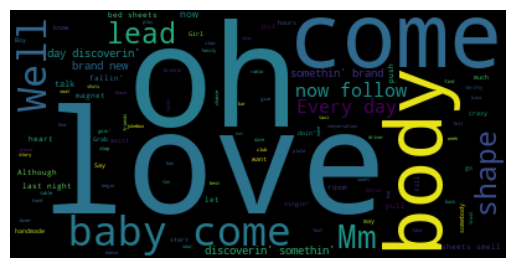

In [21]:
wordcloud = WordCloud().generate(df.iloc[0,5])

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [22]:
client_id = credentials['client_id']
client_secret = credentials['client_secret']

client_creds = f"{client_id}:{client_secret}"
base64_client_creds = b64encode(client_creds.encode()).decode()

auth_url = 'https://accounts.spotify.com/api/token'
headers = {
    'Authorization': f'Basic {base64_client_creds}'
}
payload = {
    'grant_type': 'client_credentials'
}

response = requests.post(auth_url, headers=headers, data=payload)

response.json()


{'access_token': 'BQDxMadH54l7QJH6gd7dt17Jwb7xUuJyej1U01akq9QAkmhfc9gUiBTRAgkCy8cIK1sptp551UQnSCWHHICOyDYZ3DdzyKAv5rTM1URDSh-Vm9vi8vU',
 'token_type': 'Bearer',
 'expires_in': 3600}

In [23]:
def get_release_date(song):
    client_credentials_manager = SpotifyClientCredentials(client_id=client_id, client_secret=client_secret)
    sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)
    result = sp.search(song)
    release_date = result['tracks']['items'][0]['album']['release_date']
    return release_date

In [24]:
def get_popularity(song):
    client_credentials_manager = SpotifyClientCredentials(client_id=client_id, client_secret=client_secret)
    sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)
    result = sp.search(song)
    popularity = result['tracks']['items'][0]['popularity']
    return popularity

In [25]:
def get_explicitness(song):
    client_credentials_manager = SpotifyClientCredentials(client_id=client_id, client_secret=client_secret)
    sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)
    result = sp.search(song)
    explicitness = result['tracks']['items'][0]['explicit']
    return explicitness

In [31]:
def get_market_number(song):
    client_credentials_manager = SpotifyClientCredentials(client_id=client_id, client_secret=client_secret)
    sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)
    result = sp.search(song)
    available_markets = result['tracks']['items'][0]['available_markets']
    return len(available_markets)

In [32]:
df['release_date'] = df['Song'].apply(lambda x: get_release_date(x))
df['popularity'] = df['Song'].apply(lambda x: get_popularity(x))
df['explicitness'] = df['Song'].apply(lambda x: get_explicitness(x))
df['markets'] = df['Song'].apply(lambda x: get_market_number(x))

In [49]:
df['release_date'] = pd.to_datetime(df['release_date'])
df.head()

,Artist,Song,like_count,view_count,comment_count,lyrics,sentiment_positive,sentiment_neutral,sentiment_negative,sentiment_compound,lexical_richness,song_length,sentiment_compound_absolute,release_date,popularity,explicitness,markets
1,Ed Sheeran,Shape of You,32323299,6149151955,1146136,A club isn't the best place to find a lover So...,0.229,0.757,0.014,0.9995,23,699,0.9995,2017-03-03,89,False,184
4,Maroon 5,Sugar,15906928,3972703093,418290,"I'm hurting, baby, I'm broken down I need your...",0.288,0.642,0.070,0.9988,29,472,0.9988,2020-08-25,73,True,184
5,OneRepublic,Counting Stars,17490906,3927278630,488707,"Lately, I've been, I've been losin' sleep Drea...",0.040,0.856,0.104,-0.9831,21,517,0.9831,2014-01-01,78,False,183
6,Katy Perry,Roar,16595850,3918599134,774322,I used to bite my tongue and hold my breath Sc...,0.175,0.779,0.047,0.9945,31,352,0.9945,2013-01-01,82,False,184
8,Justin Bieber,Sorry,16306693,3741548245,868546,You gotta go and get angry at all of my honest...,0.133,0.723,0.145,0.9039,35,359,0.9039,2015-11-13,86,False,166


In [52]:
def market_availability_category(x):
    number = int(x)
    if number == 184:
        return 'High'
    elif 50 < number < 184:
        return 'Medium'
    else:
        return 'Low'

In [54]:
df['markets'] = df['markets'].apply(lambda x: market_availability_category(x))
df.head()

,Artist,Song,like_count,view_count,comment_count,lyrics,sentiment_positive,sentiment_neutral,sentiment_negative,sentiment_compound,lexical_richness,song_length,sentiment_compound_absolute,release_date,popularity,explicitness,markets
1,Ed Sheeran,Shape of You,32323299,6149151955,1146136,A club isn't the best place to find a lover So...,0.229,0.757,0.014,0.9995,23,699,0.9995,2017-03-03,89,False,High
4,Maroon 5,Sugar,15906928,3972703093,418290,"I'm hurting, baby, I'm broken down I need your...",0.288,0.642,0.070,0.9988,29,472,0.9988,2020-08-25,73,True,High
5,OneRepublic,Counting Stars,17490906,3927278630,488707,"Lately, I've been, I've been losin' sleep Drea...",0.040,0.856,0.104,-0.9831,21,517,0.9831,2014-01-01,78,False,Medium
6,Katy Perry,Roar,16595850,3918599134,774322,I used to bite my tongue and hold my breath Sc...,0.175,0.779,0.047,0.9945,31,352,0.9945,2013-01-01,82,False,High
8,Justin Bieber,Sorry,16306693,3741548245,868546,You gotta go and get angry at all of my honest...,0.133,0.723,0.145,0.9039,35,359,0.9039,2015-11-13,86,False,Medium


In [55]:
corr_df = df[['like_count','view_count','comment_count', 'sentiment_positive', 'sentiment_neutral', 'sentiment_negative', 'sentiment_compound_absolute', 'lexical_richness', 'song_length', 'popularity']].corr()

In [56]:
corr_df2 = corr_df. \
        melt(ignore_index=False) \
        .reset_index()

corr_df2['rounded_value'] = corr_df2['value'].apply(lambda x: np.round(x, 2))

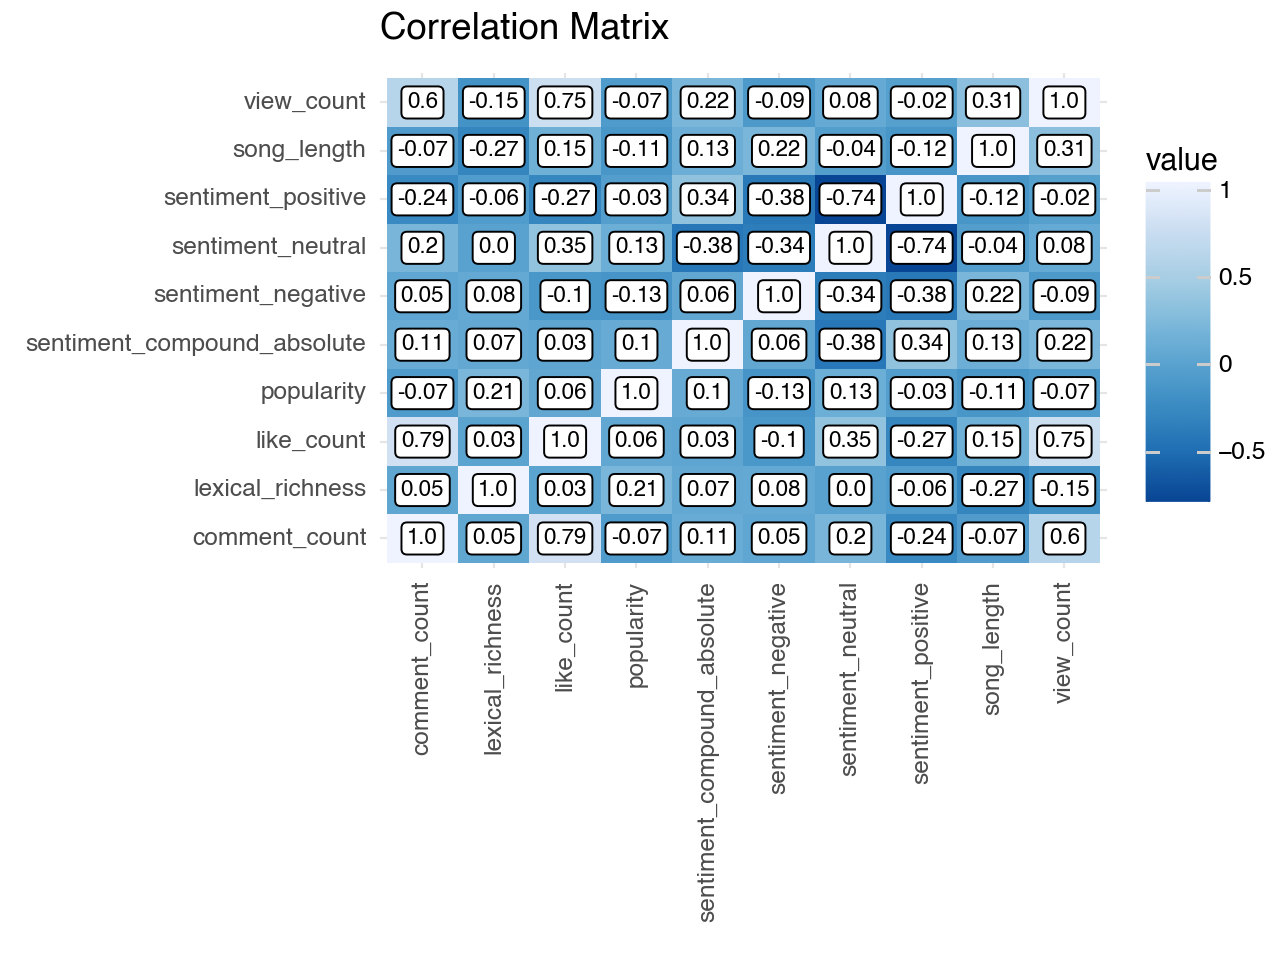

<Figure Size: (640 x 480)>

In [57]:
g = p9.ggplot(
        mapping = p9.aes('index', 'variable', fill = 'value'),
        data = corr_df2
    ) + \
        p9.geom_tile() + \
        p9.geom_label(
            p9.aes(label = 'rounded_value'),
            fill = 'white',
            size = 8
        ) + \
        p9.scale_fill_distiller() + \
        p9.theme_minimal() + \
        p9.labs(
            title = 'Correlation Matrix',
            x = '',
            y = ''
        ) + \
        p9.theme(
            axis_text_x = element_text(angle = 90)
        )

g

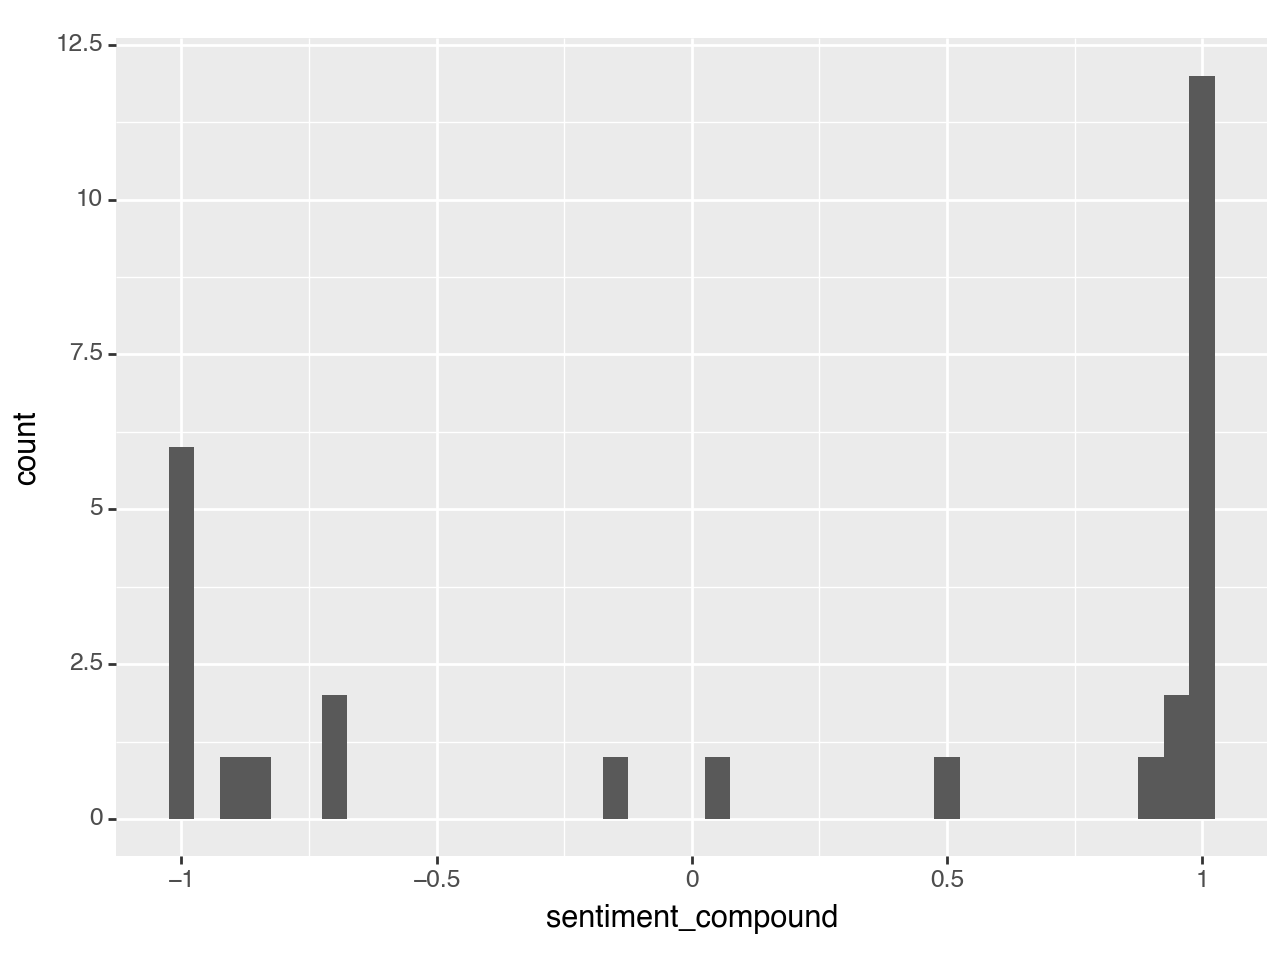

<Figure Size: (640 x 480)>

In [59]:
g = p9.ggplot(
    mapping = p9.aes(x = 'sentiment_compound'),
    data = df
) + \
geom_histogram(binwidth=0.05)

g